In [24]:
import numpy as np
import keras 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape
from keras.utils import to_categorical, np_utils

# 2 Getting Started

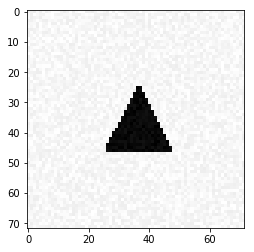

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



# 3 Simple Classification

In [24]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = to_categorical(Y_train,3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


[1. 0. 0.]


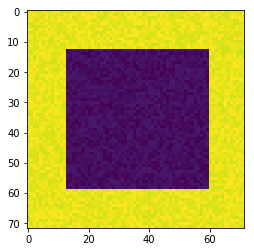

In [46]:
plt.imshow(X_train[6].reshape(72,72))
print(Y_train[6])

In [49]:
X_train.shape[0]

300

In [61]:
modelsgd = Sequential()
modelsgd.add(Dense(3, input_shape=X_train[0].shape, activation='softmax'))
modelsgd.compile(optimizer='sgd', loss = "categorical_crossentropy", metrics=['accuracy'])

In [62]:
modelsgd.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 0s 525us/step - loss: 8.1913 - acc: 0.3567
Epoch 2/10
300/300 [==============================] - 0s 90us/step - loss: 10.4230 - acc: 0.3533
Epoch 3/10
300/300 [==============================] - 0s 106us/step - loss: 10.4230 - acc: 0.3533
Epoch 4/10
300/300 [==============================] - 0s 113us/step - loss: 10.4230 - acc: 0.3533
Epoch 5/10
300/300 [==============================] - 0s 103us/step - loss: 10.4230 - acc: 0.3533
Epoch 6/10
300/300 [==============================] - 0s 103us/step - loss: 10.4230 - acc: 0.3533
Epoch 7/10
300/300 [==============================] - 0s 96us/step - loss: 10.4230 - acc: 0.3533
Epoch 8/10
300/300 [==============================] - 0s 103us/step - loss: 10.4230 - acc: 0.3533
Epoch 9/10
300/300 [==============================] - 0s 113us/step - loss: 10.4230 - acc: 0.3533
Epoch 10/10
300/300 [==============================] - 0s 113us/step - loss: 10.4230 - acc: 0.3533


In [63]:
modeladam = Sequential()
modeladam.add(Dense(3, input_shape=X_train[0].shape, activation='softmax'))
modeladam.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=['accuracy'])

In [64]:
modeladam.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 0s 655us/step - loss: 2.2795 - acc: 0.4100
Epoch 2/10
300/300 [==============================] - 0s 120us/step - loss: 1.2254 - acc: 0.4933
Epoch 3/10
300/300 [==============================] - 0s 123us/step - loss: 0.7753 - acc: 0.6700
Epoch 4/10
300/300 [==============================] - 0s 110us/step - loss: 0.5027 - acc: 0.7533
Epoch 5/10
300/300 [==============================] - 0s 113us/step - loss: 0.3727 - acc: 0.8867
Epoch 6/10
300/300 [==============================] - 0s 106us/step - loss: 0.3365 - acc: 0.8867
Epoch 7/10
300/300 [==============================] - 0s 113us/step - loss: 0.2911 - acc: 0.9467
Epoch 8/10
300/300 [==============================] - 0s 103us/step - loss: 0.2592 - acc: 0.9467
Epoch 9/10
300/300 [==============================] - 0s 116us/step - loss: 0.2210 - acc: 0.9833
Epoch 10/10
300/300 [==============================] - 0s 103us/step - loss: 0.2103 - acc: 0.9600


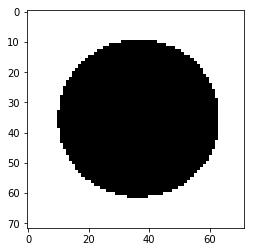

In [66]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
plt.imshow(X_test.reshape(72,72), cmap='gray')

In [67]:
modeladam.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

The disk is correctly predicted in the second class

# 4 Visualization of the Solution

In [84]:
weights= modeladam.get_weights()

In [88]:
weights[0][:,0].shape

(5184,)

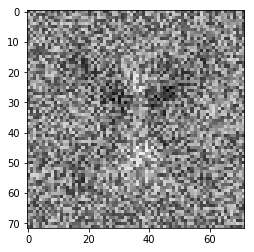

In [87]:
plt.imshow(weights[0][:,0].reshape(72,72), cmap='gray')

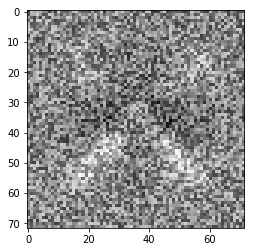

In [89]:
plt.imshow(weights[0][:,1].reshape(72,72), cmap='gray')

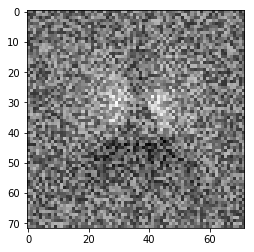

In [90]:
plt.imshow(weights[0][:,2].reshape(72,72), cmap='gray')

This shows which neurons are activated given an input of different classes

# 5 A More Difficult Classification Problem

### Linear Classifier

In [112]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = to_categorical(Y_train,3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [113]:
modeladam = Sequential()
modeladam.add(Dense(3, input_shape=X_train[0].shape, activation='softmax'))
modeladam.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=['accuracy'])

In [114]:
modeladam.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 0s 1ms/step - loss: 1.8066 - acc: 0.3367
Epoch 2/10
300/300 [==============================] - 0s 96us/step - loss: 1.1306 - acc: 0.4033
Epoch 3/10
300/300 [==============================] - 0s 96us/step - loss: 1.0727 - acc: 0.4367
Epoch 4/10
300/300 [==============================] - 0s 106us/step - loss: 0.9982 - acc: 0.4833
Epoch 5/10
300/300 [==============================] - 0s 126us/step - loss: 0.9706 - acc: 0.5233
Epoch 6/10
300/300 [==============================] - 0s 106us/step - loss: 0.9393 - acc: 0.5633
Epoch 7/10
300/300 [==============================] - 0s 103us/step - loss: 0.9910 - acc: 0.5600
Epoch 8/10
300/300 [==============================] - 0s 110us/step - loss: 1.0372 - acc: 0.5300
Epoch 9/10
300/300 [==============================] - 0s 130us/step - loss: 0.9072 - acc: 0.5633
Epoch 10/10
300/300 [==============================] - 0s 120us/step - loss: 0.8790 - acc: 0.5867


In [115]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [116]:
modeladam.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 313us/step


[0.8954845627148946, 0.4999999996026357]

Loss function close to 0.9 & accuracy 50%

## Increasing the size of the train set

In [117]:
[X_train, Y_train] = generate_dataset_classification(1500, 20, True)
Y_train = to_categorical(Y_train,3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490


In [118]:
modeladam = Sequential()
modeladam.add(Dense(3, input_shape=X_train[0].shape, activation='softmax'))
modeladam.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=['accuracy'])

In [119]:
modeladam.fit(X_train,Y_train, epochs=10 , batch_size=32)

Epoch 1/10
1500/1500 [==============================] - 0s 233us/step - loss: 1.5477 - acc: 0.3867
Epoch 2/10
1500/1500 [==============================] - 0s 90us/step - loss: 0.9437 - acc: 0.5333
Epoch 3/10
1500/1500 [==============================] - 0s 92us/step - loss: 1.0475 - acc: 0.5227
Epoch 4/10
1500/1500 [==============================] - 0s 92us/step - loss: 0.8771 - acc: 0.5647
Epoch 5/10
1500/1500 [==============================] - 0s 104us/step - loss: 0.8721 - acc: 0.5700
Epoch 6/10
1500/1500 [==============================] - 0s 115us/step - loss: 0.8681 - acc: 0.5620
Epoch 7/10
1500/1500 [==============================] - 0s 115us/step - loss: 0.8561 - acc: 0.5780
Epoch 8/10
1500/1500 [==============================] - 0s 110us/step - loss: 0.8102 - acc: 0.6060
Epoch 9/10
1500/1500 [==============================] - 0s 106us/step - loss: 0.8365 - acc: 0.6067
Epoch 10/10
1500/1500 [==============================] - 0s 104us/step - loss: 0.7838 - acc: 0.6233


In [120]:
modeladam.evaluate(X_test,Y_test)

300/300 [==============================] - 0s 309us/step


[0.7700569081306458, 0.5933333333333334]

The loss function decreased currently to 0.77 & test accuracy increased up to 59.3%

## Convolutional Neural Network

In [121]:
X_train=X_train.reshape(1500, 72, 72, 1)
X_test=X_test.reshape(300, 72, 72, 1)
X_train.shape

(1500, 72, 72, 1)

In [125]:
modelCNN = Sequential()
modelCNN.add(Conv2D(16,(5,5),activation='relu',input_shape=(72,72,1)))
modelCNN.add(MaxPooling2D(pool_size=(2,2)))
modelCNN.add(Flatten())
modelCNN.add(Dense(3, activation = "softmax"))
modelCNN.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=['accuracy'])

In [126]:
modelCNN.fit(X_train, Y_train, epochs=30, batch_size=32)

Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.9831 - acc: 0.5560
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6715 - acc: 0.7387
Epoch 3/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5600 - acc: 0.7960
Epoch 4/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4925 - acc: 0.8387
Epoch 5/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4473 - acc: 0.8400
Epoch 6/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3872 - acc: 0.8760A: 0s - loss: 0.3871 - acc: 0.877
Epoch 7/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3439 - acc: 0.9007A: 1s - loss: 0.350
Epoch 8/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3122 - acc: 0.9093
Epoch 9/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2710 - acc: 0.9267
Epoch 10/30
1500/1500 [==============================] - 6s 4ms/step - loss

In [127]:
modelCNN.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 2ms/step


[0.24908863226572672, 0.9200000007947285]

The convolutional neural network performs way better than the dense architecture since the loss function dropped to 0.25 & accuracy test is now 92%

# 6 A Reggression Problem

In [128]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [133]:
X_train=X_train.reshape(300, 72, 72, 1)
X_train.shape

(300, 72, 72, 1)

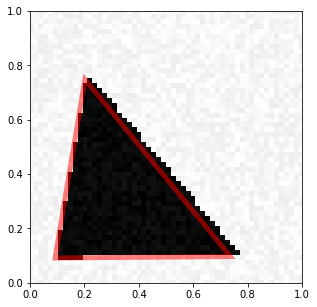

In [138]:
visualize_prediction(X_train[0], Y_train[0])

In [131]:
modelCNN = Sequential()
modelCNN.add(Conv2D(16,(5,5),activation='relu',input_shape=(72,72,1)))
modelCNN.add(MaxPooling2D(pool_size=(2,2)))
modelCNN.add(Flatten())
modelCNN.add(Dense(6, activation = "softmax"))
modelCNN.compile(optimizer = 'adam', loss = "mean_squared_error", metrics=['accuracy'])

In [134]:
modelCNN.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2085 - acc: 0.1700
Epoch 2/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1969 - acc: 0.2267
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1871 - acc: 0.2867
Epoch 4/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1804 - acc: 0.3667
Epoch 5/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1757 - acc: 0.4667
Epoch 6/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1732 - acc: 0.4333
Epoch 7/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1703 - acc: 0.5267
Epoch 8/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1679 - acc: 0.5733
Epoch 9/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1655 - acc: 0.6100
Epoch 10/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - acc: 0.6133
Epoch 11/100
300/300 [=================

In [135]:
[X_test, Y_test] = generate_test_set_regression()
X_test=X_test.reshape(300, 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [136]:
modelCNN.evaluate(X_test,Y_test)

300/300 [==============================] - 1s 2ms/step


[0.2147802495956421, 0.21000000019868215]

We need to rearrange vertices to help the neural network recongnize vertices better. We also increase the size of the train sample

In [149]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [150]:
X_train=X_train.reshape(3000, 72, 72, 1)
X_train.shape

(3000, 72, 72, 1)

In [230]:
def Vertices_sort(V):
    Vr = V.reshape(len(V), 3, 2)
    Vc = Vr.copy()
    Sorted_ind = np.argsort(V[:, ::2], axis=1)
    for i, j in enumerate(Sorted_ind):
        Vc[i, :] = Vc[i,j]
    return Vc.reshape(-1, 6)

In [231]:
Y_train=Vertices_sort(Y_train)
Y_test=Vertices_sort(Y_test)

In [218]:
modelCNN = Sequential()
modelCNN.add(Conv2D(16,(5,5),activation='relu',input_shape=(72,72,1)))
modelCNN.add(MaxPooling2D(pool_size=(2,2)))
modelCNN.add(Conv2D(32, (3,3), activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=(2,2)))
modelCNN.add(Flatten())
modelCNN.add(Dense(1000, activation='relu'))
modelCNN.add(Dropout(0.1))
modelCNN.add(Dense(1000, activation='relu'))
modelCNN.add(Dropout(0.25))
modelCNN.add(Dense(6))
modelCNN.compile(optimizer = 'adam', loss = "mean_squared_error", metrics=['accuracy'])

In [219]:
modelCNN.fit(X_train, Y_train, epochs=15, batch_size=128)

Epoch 1/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2922 - acc: 0.3877
Epoch 2/15
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0520 - acc: 0.5207
Epoch 3/15
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0363 - acc: 0.5607
Epoch 4/15
3000/3000 [==============================] - 18s 6ms/step - loss: 0.0272 - acc: 0.6103
Epoch 5/15
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0209 - acc: 0.6703
Epoch 6/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.0169 - acc: 0.7077
Epoch 7/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.0145 - acc: 0.7533
Epoch 8/15
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0132 - acc: 0.7473
Epoch 9/15
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0115 - acc: 0.7647
Epoch 10/15
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0101 - acc: 0.7883
Epoch 11/15
3000/30

In [232]:
modelCNN.evaluate(X_test,Y_test)

300/300 [==============================] - 1s 3ms/step


[0.008562463608880837, 0.826666665871938]

In [233]:
prediction = modelCNN.predict(X_test)

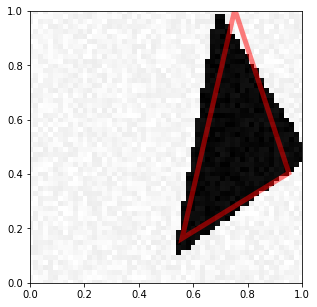

In [234]:
i=55
visualize_prediction(X_test[i], prediction[i])

We got better predictions and loss function decreased to 0.008

# 7 Image Denoising

In [28]:
def generate_pair_images(nb_samples, max_amplitude=30, free_location=False):    
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    XN = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise=np.random.randint(max_amplitude)
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(0.0, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(0.0, free_location)
        else:
            [X[i], V] = generate_a_triangle(0.0, free_location)
        XN[i] = X[i] + noise*np.random.random(im_size)
    XN = (XN + noise) / (255 + 2 * noise)
    X /= 255
    return [X, XN]

In [40]:
X_clean,X_noise=generate_pair_images(3000,free_location=True)
X_clean = X_clean.reshape(len(X_clean), 72, 72, 1)
X_noise = X_noise.reshape(len(X_noise), 72, 72, 1)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


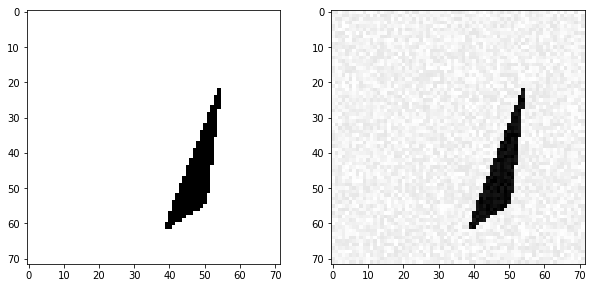

In [50]:
fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(X_clean[1].reshape(72,72), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_noise[1].reshape(72,72), cmap='gray')
plt.show()

In [45]:
model=Sequential()
model.add(Conv2D(16,kernel_size=3,strides=2,padding='same',input_shape=(72,72,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32,kernel_size=3,strides=2,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2DTranspose(32,kernel_size=3,strides=2,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2DTranspose(16,kernel_size=3,strides=2,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2DTranspose(1,kernel_size=3,activation='sigmoid',padding='same'))

In [46]:
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [47]:
model.fit(X_noise, X_clean,batch_size=64,epochs=10, validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/10
2700/2700 [==============================] - 57s 21ms/step - loss: 0.0820 - acc: 0.9475 - val_loss: 0.0235 - val_acc: 0.9898
Epoch 2/10
2700/2700 [==============================] - 53s 20ms/step - loss: 0.0094 - acc: 0.9953 - val_loss: 0.0080 - val_acc: 0.9966
Epoch 3/10
2700/2700 [==============================] - 53s 20ms/step - loss: 0.0043 - acc: 0.9978 - val_loss: 0.0048 - val_acc: 0.9983
Epoch 4/10
2700/2700 [==============================] - 52s 19ms/step - loss: 0.0027 - acc: 0.9985 - val_loss: 0.0032 - val_acc: 0.9987
Epoch 5/10
2700/2700 [==============================] - 53s 20ms/step - loss: 0.0019 - acc: 0.9989 - val_loss: 0.0022 - val_acc: 0.9991
Epoch 6/10
2700/2700 [==============================] - 53s 20ms/step - loss: 0.0015 - acc: 0.9992 - val_loss: 0.0017 - val_acc: 0.9992
Epoch 7/10
2700/2700 [==============================] - 53s 20ms/step - loss: 0.0012 - acc: 0.9994 - val_loss: 0.0013 - val_acc: 0.9995
E

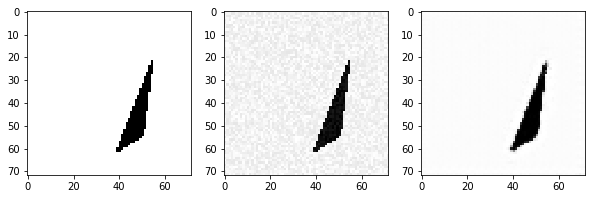

In [51]:
i=1
fig = plt.figure(figsize = (10,8))
plt.subplot(1,3,1)
plt.imshow(X_clean[i].reshape(72,72), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(X_noise[i].reshape(72,72), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(model.predict(X_noise)[i].reshape(72,72), cmap='gray')
plt.show()

The image denoising network is performing very well (the noise is between 0 & 30 i.e max_noise=30)